<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ds-kiel/TinyML-Labs/blob/WS24-25/Lab2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ds-kiel/TinyML-Labs/blob/WS24-25/Lab2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/ds-kiel/TinyML-Labs/WS24-25/Lab2.ipynb" download><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Quantization and On-Device Execution (Lab 2 & 3)

In the first lab you looked at the first part of the pipeline from data to executing models on low-power devices. You explored how to preprocess data and train neural networks with Edge Impulse. In this lab we continue the pipeline and you will explore how to [convert](https://ai.google.dev/edge/litert/models/convert_tf) a model to a [LiteRT](https://ai.google.dev/edge/litert) model, how to [quantize](https://ai.google.dev/edge/litert/models/post_training_integer_quant) [a model](https://www.tensorflow.org/model_optimization/guide/quantization/post_training), how to use [quantization-aware training](https://www.tensorflow.org/model_optimization/guide/quantization/training) and finally how to deploy the model and use the model with a microcontroller. **Come back to these documents in case you get stuck**.

You will explore the full pipeline from data to device using Tensorflow. You will train a model and convert, deploy, and execute it on a microcontroller, specifically the [Arduino Nano 33 BLE Sense](https://store.arduino.cc/products/arduino-tiny-machine-learning-kit).

This file is for both labs 2 and 3. Lab 2 is about generating a model in TF and quanizizing it. Lab 3 is then about the deployment.

## Environment

The instructions for this lab come as a [Jupyter Notebook](https://jupyter.org/). You can run it locally in your own Python environment, but we recommend you to use [Google Colab](https://colab.research.google.com) to save your compute ressources, have an instantly working python environment, and allow for easy collaboration. If your decide to use your local computer, take a look at Python virtual environments to avoid messing with your usual Python environment.

## What do you need to hand in?

Please complete the tasks by (a) completing the coding tasks and (b) answer the questions (please write a few lines directly in the notebook after the **Answer:** element). Thus, this Jupyter Notebook is intended as a document that you use both for working on the lab as well as for answering the questions. Once completed with lab 2 (or lab 3) let the teacher know. Be ready to demonstrate your results and show your code & answers to the tasks.

# Lab 2: Quantization

## Setup

In [65]:
# If you have not done so already, install the following dependencies (if you are in a local envoronment, you might need to install some more)
!python -m pip install tensorflow>=2.3 matplotlib seaborn cbor2

zsh:1: 2.3 not found


### Imports

In [3]:
import numpy as np
import pandas as pd
import os
import cbor2

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, ReLU, Add, Input, SeparableConv1D
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#import edgeimpulse as ei

import matplotlib.pyplot as plt
import seaborn as sns

#disable this if you are not using Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

### Helper Functions

In [4]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Model {model_name}')
    fig.set_figwidth(15)

    ax1.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'])
    ax1.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['training', 'validation'], loc='best')

    ax2.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
    ax2.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['training', 'validation'], loc='best')
    plt.show()

## Edge Impulse Dataset

### Prepare the data

---
**Task 1:** Navigate to the *Data acquisition* page in your Edge Impulse project of lab 1 and export the data.

**Task 2:** Import the data with the code below.

---

In [5]:
labels = ['idle', 'circle', 'left-right', 'up-down'] # Change this to your labels if needed
num_classes = len(labels)

data_path = './data/' # Change this to the path of your downloaded folder

# Select the window size and stride you used in Edge Impulse
window_size_ms = 2000
window_stride_ms = 100


# Function to create windows from the data
def create_windows(df, window_size_ms, window_stride_ms, label):
    window_size = int(window_size_ms / 10)
    window_stride = int(window_stride_ms / 10)
    windows = []
    windows_labels = []
    for i in range(0, len(df) - window_size, window_stride):
        windows.append(df.iloc[i:i+window_size].values)
        windows_labels.append(label)
    return np.array(windows),windows_labels

# Load the data from the files
def load_data(data_path, folder):
    data = np.zeros((1, int(window_size_ms / 10), 3))
    data_labels = []
    for file in os.listdir(data_path+folder):
        if file.endswith('.cbor'):
            label = file.split('.')[0].strip()
            with open(data_path+folder+'/'+file, 'rb') as f_obj:
                data_file = cbor2.load(f_obj)
                df = pd.DataFrame(data_file['payload']['values'], columns=[item['name'] for item in data_file['payload']['sensors']])
                df = df.drop(columns=['gyrX', 'gyrY', 'gyrZ', 'magX', 'magY', 'magZ'])

                window_data, window_labels = create_windows(df, window_size_ms, window_stride_ms, labels.index(label))
                data = np.concatenate((data, window_data), axis=0)
                data_labels += window_labels

    data = np.delete(data, 0, axis=0)
    return data, data_labels


x_train, y_train = load_data(data_path, 'training')
x_test, y_test = load_data(data_path, 'testing')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

---
**Task 3 (optional):** Perform scaling on your data if you like to. *Please note: You have to do the same scaling later in your Arduino program.*

---

In [69]:
# perform your scaling here

### Build the model

---
**Task 4:** Add your best model from lab 1, that uses a raw data preprocessing block.

---

In [ ]:
# Build model

def bottleneck_block(x, filters, dilation_rate):
    # 1×1 “pointwise” compression
    y = Conv1D(filters//4, kernel_size=1, activation='relu')(x)
    # Dilated convolution
    y = Conv1D(filters//4, kernel_size=5, dilation_rate=dilation_rate,
               padding='same', activation='relu')(y)
    # Restore channels
    y = Conv1D(filters, kernel_size=1, activation='relu')(y)
    return y

def residual_block(x, filters):
    shortcut = x
    y = Conv1D(filters,  kernel_size=3, padding='same')(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Conv1D(filters, kernel_size=3, padding='same')(y)
    y = BatchNormalization()(y)
    # Add skip connection
    out = Add()([shortcut, y])
    return ReLU()(out)

def build_model(summary=True):
    inp = Input(shape=(200,3))

    # Initial separable conv
    x = SeparableConv1D(16, 5, activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)

    # Bottleneck + dilated conv
    x = bottleneck_block(x, filters=32, dilation_rate=2)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)

    # Residual refinement
    x = residual_block(x, filters=32)
    x = MaxPooling1D(2)(x)

    # Classifier head
    x = Flatten()(x)
    x = Dense(32, activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax', name='y_pred')(x)

    model = Model(inputs=inp, outputs=out)

    # model = Sequential([
    #     Conv1D(16, kernel_size=5, activation='relu', input_shape=(200,3)),
    #     BatchNormalization(),
    #     MaxPooling1D(pool_size=2),

    #     Conv1D(32, kernel_size=5, activation='relu'),
    #     BatchNormalization(),
    #     MaxPooling1D(pool_size=2),

    #     Flatten(),

    #     Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    #     Dropout(0.3),

    #     Dense(num_classes, activation='softmax', name='y_pred')
    # ])


    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    if summary:
        model.summary()

    return model

In [52]:
model = build_model()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 200, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_3  │ (None, 200, 16)   │         79 │ input_layer_10[0… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 16)   │         64 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 100, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 100, 8)    │        136 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 100, 8)    │        328 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 100, 32)   │        288 │ conv1d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 50, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 50, 32)    │      3,104 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 32)    │        128 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 50, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 50, 32)    │      3,104 │ re_lu_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 32)    │        128 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 50, 32)    │          0 │ max_pooling1d_17… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 50, 32)    │          0 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 25, 32)    │          0 │ re_lu_16[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 800)       │          0 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │     25,632 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_8[0][0]   

 Total params: 33,251 (129.89 KB)

 Trainable params: 33,027 (129.01 KB)

 Non-trainable params: 224 (896.00 B)

### Train the model

So far, you manually explored how many epochs are necessary to successfully train the model. However, Tensorflow gives you an option to automate this called [early stopping](https://keras.io/api/callbacks/early_stopping/). See also [here](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) and [here](https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd).

---
**Task 7:** Use an early stopping callback in your fitting function to find the optimal number of epochs. Use reasonable configurations. How many epochs does it train for?

**Answer:**


- monitor="val_loss" -> "val_loss is the value of cost function for your cross-validation data and loss is the value of cost function for your training data" [source](https://datascience.stackexchange.com/a/25269)
- patience=10 -> jiggles some times up and down, want to continue after that to use the given training epochs more
- min_delta=0.01 -> force some minimum improvment
- mode='min' -> val_loss needs to be minimized
- restore_best_weights=True -> want to restore the weights that gave the best val_loss



---

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4209 - loss: 2.1549 - val_accuracy: 0.3153 - val_loss: 1.5526
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7513 - loss: 0.8562 - val_accuracy: 0.3578 - val_loss: 1.5070
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9058 - loss: 0.3493 - val_accuracy: 0.4236 - val_loss: 1.3661
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9558 - loss: 0.1637 - val_accuracy: 0.4700 - val_loss: 1.3576
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9805 - loss: 0.0701 - val_accuracy: 0.6867 - val_loss: 1.4239
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9920 - loss: 0.0313 - val_accuracy: 0.7253 - val_loss: 1.1665
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9903 - loss: 0.0420 - val_accuracy: 0.7776 - val_loss: 0.9955
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9944 - loss: 0.0227 - val_accuracy: 0.8162 - v

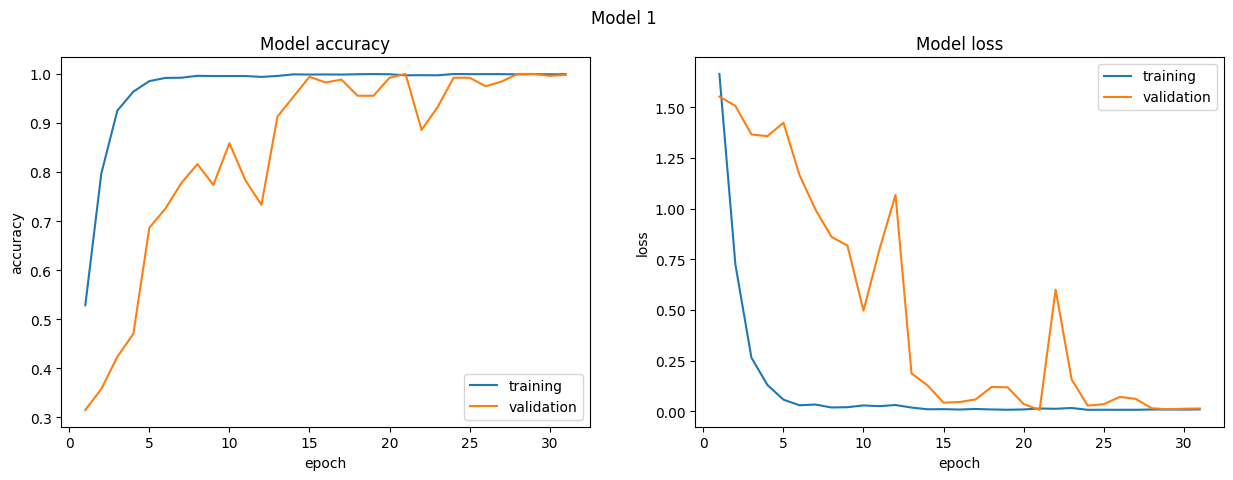

In [ ]:

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.01,
    mode='min',
    restore_best_weights=True
)
callbacks=[early_stopping_cb, ]
# callbacks=[]

history = model.fit(x_train, y_train, batch_size=128, epochs=num_epochs, validation_split=0.1, callbacks=callbacks)
plot_training_history(history, 1)

### Evaluate the Model



41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9977 - loss: 0.0129
Test loss: 0.024012582376599312
Test accuracy: 0.9930340647697449
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


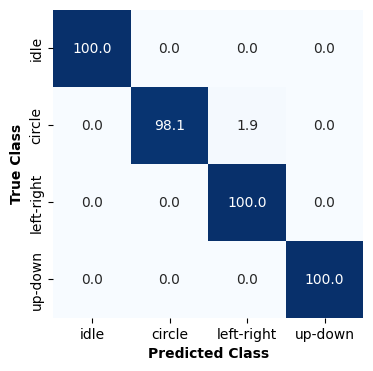

In [57]:
score_model = model.evaluate(x_test, y_test) #, verbose=0)
print("Test loss:", score_model[0])
print("Test accuracy:", score_model[1])

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(x_test),axis=1))
# print(cm)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm = pd.DataFrame(cm, index = labels,
                  columns = labels)

plt.figure(figsize = (4,4))
ax = sns.heatmap(cm*100,
           annot=True,
           fmt='.1f',
           cmap="Blues",
           cbar=False,
              )
ax.set_ylabel("True Class", fontdict= {'fontweight':'bold'})
ax.set_xlabel("Predicted Class", fontdict= {'fontweight':'bold'})

plt.show()

---
**Task 8:** How does the accuracy of your model compare to the accuracy you achieved with Edge Impulse?

There seem to be some issues with the random initialization. The same model performed much better on EdgeImpulse. Started multiple runs to achieve similar result.

![CNN+Dense Large Validation](./lab2_validation_cnn_dense_large_2.png)

![CNN+Dense Large Validation](./edge_impulse_cnn_dense_large.png)

Therefore, we introduced a more advanced architecture.

![Advanced Architecture Validation](./lab2_validation_advanced_large.png)

![Advanced Architecture Edge Impulse](./edge_impulse_advanced_architecture_large.png)

---

### Save Model

To come back to a model to continue working on it, it might be useful to save it. We can use the `model.save()` [Function](https://www.tensorflow.org/guide/keras/serialization_and_saving) that exports a TensorFlow model object to SavedModel format.

If you use Google Colab, you can find the saved model as a `.keras`-file on the left under `Files/`.

In [58]:
from datetime import datetime

export_base_path = f'./models/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_advanced_large_retrained'
model.save(f"{export_base_path}.keras")

### Model Quantization

Your microcontroller cannot use the Tensoflow model directly. Instead there is [LiteRT](https://ai.google.dev/edge/litert) for deploying models on mobile and edge devices.

---
**Task 9:** Load your model and convert it with LiteRT and save the model to a `.tflite`-file. (HINT: Check out [this](https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world) *Hello World* example and [these instructions](https://ai.google.dev/edge/litert/models/convert_tf).)

**Task 10:** Create a second LiteRT conversion that uses [optimizations](https://ai.google.dev/edge/api/tflite/python/tf/lite/Optimize) and enforce integer-only weights.
(Maybe a helpful [resource](https://ai.google.dev/edge/litert/models/post_training_quantization).)

**Task 11:** Evaluate all converted models and compare them to the Tensorflow model they are based on regarding profiled memory usage and accuracy. Use plots.

```[bash]
ls -lh models/
-rw-r--r--@ 1 ture  staff   485K Apr 27 17:39 2025-04-27_17-39-12_advanced_architecture.keras
-rw-r--r--@ 1 ture  staff   143K May  6 22:21 2025-05-06_21-16-36_advanced_architecture-basic.tflite
-rw-r--r--@ 1 ture  staff    51K May  6 22:21 2025-05-06_21-16-36_advanced_architecture-optimized.tflite
-rw-r--r--@ 1 ture  staff    51K May  6 22:21 2025-05-06_21-16-36_advanced_architecture-quantized.tflite
```

Therefore, the quantized and optimized model has ~60% reduction in size compared to the base tflite model and a 89% size reduction to the orignial model.

```
=== ORIGINAL MODEL ===
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Model accuracy: 0.9729
Estimated RAM usage: N/A for Keras model

=== BASIC MODEL ===
Model accuracy: 0.9837
Estimated RAM usage (tensor buffers only): 375.41 KB

=== OPTIMIZED MODEL ===
Model accuracy: 0.9837
Estimated RAM usage (tensor buffers only): 282.41 KB

=== QUANTIZED MODEL ===
Model accuracy: 0.9226
Estimated RAM usage (tensor buffers only): 96.78 KB
```

Quite curiosly this accuracy drop disappeared after retraining the model:

```
=== ORIGINAL MODEL ===
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Model accuracy: 0.9930
Estimated RAM usage: N/A for Keras model

=== BASIC MODEL ===
Model accuracy: 0.9837
Estimated RAM usage (tensor buffers only): 375.41 KB

=== OPTIMIZED MODEL ===
Model accuracy: 0.9837
Estimated RAM usage (tensor buffers only): 282.41 KB

=== QUANTIZED MODEL ===
Model accuracy: 0.9861
Estimated RAM usage (tensor buffers only): 96.78 KB
```

**Task 12:** Explain your findings from the previous task. Why is there such a difference in performance and in memory usage?

**Answer:**


---

In [55]:
# optional: reload model
# model = tf.keras.models.load_model('./models/2025-04-24_12-30-14_cnn_large.keras')
# model.summary()

basic_converter = tf.lite.TFLiteConverter.from_keras_model(model)
basic_tflite_model = basic_converter.convert()


optimized_converter = tf.lite.TFLiteConverter.from_keras_model(model)
optimized_converter.optimizations = [tf.lite.Optimize.DEFAULT]
optimized_tflite_model = optimized_converter.convert()

def representative_dataset_gen():
    for i in range(len(x_train)):
        yield [np.expand_dims(x_train[i].astype(np.float32), axis=0)]

optimized_converter.representative_dataset = representative_dataset_gen
optimized_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
optimized_converter.inference_input_type = tf.float32
optimized_converter.inference_output_type = tf.float32

quantized_tflite_model = optimized_converter.convert()


INFO:tensorflow:Assets written to: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmp5oq4b98m/assets


INFO:tensorflow:Assets written to: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmp5oq4b98m/assets


Saved artifact at '/var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmp5oq4b98m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='keras_tensor_124')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  16870682896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870686352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870686160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870683664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16314363216

W0000 00:00:1746646496.906065 7765540 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746646496.906074 7765540 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-07 21:34:56.906158: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmp5oq4b98m
2025-05-07 21:34:56.906798: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-07 21:34:56.906802: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmp5oq4b98m
2025-05-07 21:34:56.915672: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-07 21:34:56.959529: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmp5oq4b98m
2025-05-07 21:34:56.973523: I tensorflow/cc/saved_model/loader.cc:

INFO:tensorflow:Assets written to: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpkwmi923b/assets


INFO:tensorflow:Assets written to: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpkwmi923b/assets


Saved artifact at '/var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpkwmi923b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='keras_tensor_124')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  16870682896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870686352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870686160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870683664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16314363216

W0000 00:00:1746646497.394078 7765540 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746646497.394087 7765540 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-07 21:34:57.394172: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpkwmi923b
2025-05-07 21:34:57.394757: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-07 21:34:57.394761: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpkwmi923b
2025-05-07 21:34:57.402604: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-07 21:34:57.445170: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpkwmi923b
2025-05-07 21:34:57.458469: I tensorflow/cc/saved_model/loader.cc:

INFO:tensorflow:Assets written to: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpculd9mgu/assets


INFO:tensorflow:Assets written to: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpculd9mgu/assets


Saved artifact at '/var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpculd9mgu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='keras_tensor_124')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  16870682896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870686352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870685584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870686160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870684240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16870683664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16314363216

/Users/ture/projects/tiny-ml/env/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1746646497.887759 7765540 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746646497.887768 7765540 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-07 21:34:57.887861: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpculd9mgu
2025-05-07 21:34:57.888533: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-07 21:34:57.888537: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/t_/zj_f3xqx0h1_m2mq82vhpy_00000gn/T/tmpculd9mgu
2025-05-07 21:34:57.896452: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-07 21:34:57.939053: I tensorfl

In [59]:
# Save the converted model

with open(f"{export_base_path}-basic.tflite", 'wb') as f:
    f.write(basic_tflite_model)

with open(f"{export_base_path}-optimized.tflite", 'wb') as f:
    f.write(optimized_tflite_model)

with open(f"{export_base_path}-quantized.tflite", 'wb') as f:
    f.write(optimized_tflite_model)

In [60]:
def evaluate_model(model, dtype=None):
    if isinstance(model, tf.keras.Model):
        predictions = model.predict(x_test, batch_size=1)
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(y_test, axis=1)
        accuracy = np.mean(pred_labels == true_labels)
        print(f"Model accuracy: {accuracy:.4f}")
        # RAM usage estimation doesn't apply to Keras
        print("Estimated RAM usage: N/A for Keras model")
    else:
        # Load TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_content=model)
        interpreter.allocate_tensors()


        # Get input/output tensor details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Evaluate on test data
        correct = 0
        total = len(x_test)
        for i in range(total):
            input_data = np.expand_dims(x_test[i].astype(dtype), axis=0)
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output = interpreter.get_tensor(output_details[0]['index'])
            pred_label = np.argmax(output)
            true_label = np.argmax(y_test[i])
            if pred_label == true_label:
                correct += 1

        accuracy = correct / total
        print(f"Model accuracy: {accuracy:.4f}")

        tensor_details = interpreter.get_tensor_details()
        total_tensor_bytes = 0
        for tensor in tensor_details:
            shape = tensor['shape']
            dtype = np.dtype(tensor['dtype'])
            size = np.prod(shape) * dtype.itemsize
            total_tensor_bytes += size

        print(f"Estimated RAM usage (tensor buffers only): {total_tensor_bytes / 1024:.2f} KB")

print("=== ORIGINAL MODEL ===")
evaluate_model(model)
print("")
print("=== BASIC MODEL ===")
evaluate_model(basic_tflite_model, np.float32)
print("")
print("=== OPTIMIZED MODEL ===")
evaluate_model(optimized_tflite_model, np.float32)
print("")
print("=== QUANTIZED MODEL ===")
evaluate_model(quantized_tflite_model, np.float32)

=== ORIGINAL MODEL ===
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Model accuracy: 0.9930
Estimated RAM usage: N/A for Keras model

=== BASIC MODEL ===
Model accuracy: 0.9837
Estimated RAM usage (tensor buffers only): 375.41 KB

=== OPTIMIZED MODEL ===
Model accuracy: 0.9837
Estimated RAM usage (tensor buffers only): 282.41 KB

=== QUANTIZED MODEL ===
Model accuracy: 0.9861
Estimated RAM usage (tensor buffers only): 96.78 KB


/Users/ture/projects/tiny-ml/env/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# Lab 3: Deployment

Now, that you have designed and trained a quantized model, it is time to deploy it.

### Model Export - Library Creation

Up until now we created different models that we can test and evaluate using Python. However, most microcontrollers don't speak Python. Instead they work with C/C++ and thus we need a C(++) library of the models to execute it. Here you explore different ways to export your models to a C(++) library.

#### Manual conversion of the model

---
**Task 21:** Convert your best performing quantized model to a C++ library with the code below and explain the content of the two resulting files.

**Answer:** ...

---

In [ ]:
!apt-get update && apt-get -qq install xxd

In [ ]:
MODEL_TFLITE = 'model.tflite' #enter the name of your TFlite file uploaded to the folders section
MODEL_TFLITE_MICRO = 'model.cc' #update the name of your .cc file (This can be anything)
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
LIBRARY_NAME = 'gesture_model'
max_label_str_length = max([len(lbl) for lbl in labels]) + 1

model_str = f"alignas(16) const unsigned char {LIBRARY_NAME}[] = "
with open(MODEL_TFLITE_MICRO, 'r') as file:
    data = file.read();
    model_str += data[data.index("{"): len(data)].replace("unsigned", "const")

labels_str = f"const char available_classes[][{max_label_str_length}] = {{"
for i in range(0, len(labels)):
    if i != 0:
        labels_str += ", "
    labels_str += "\""+labels[i]+"\""
labels_str += "};"

output_str = f"#include \"{LIBRARY_NAME}.h\"\n"
output_str += labels_str + "\n"
output_str += "const int available_classes_num = "+str(len(labels)) +";\n"
output_str += model_str

with open(f"{LIBRARY_NAME}.cpp", "w") as file:
    file.write(output_str)

header_str = "#ifndef TENSORFLOW_LITE_MODEL_H_\n#define TENSORFLOW_LITE_MODEL_H_\n\n"
header_str += "// Classes that can be detected by the neural network\n"
header_str += f"extern const char available_classes[][{max_label_str_length}];\n"
header_str += "extern const int available_classes_num;\n\n"
header_str += "// Pre-trained netural network\n"
header_str += f"extern const unsigned char {LIBRARY_NAME}[];\n"
header_str += f"extern const int {LIBRARY_NAME}_len;\n\n"
header_str += "#endif /* TENSORFLOW_LITE_MODEL_H_ */"

with open(f"{LIBRARY_NAME}.h", "w") as file:
    file.write(header_str)


Next you will use your library in an Arduino program to (or if you prefer, in a Zephyr program) and execute the [inference on a microcontroller](https://ai.google.dev/edge/litert/microcontrollers/get_started). I strongly recommend you to use [this](https://docs.arduino.cc/tutorials/nano-33-ble-sense/get-started-with-machine-learning) Arduino example as a starting point to write the code. (If you prefer to use Zephyr, have a look at [this](https://docs.zephyrproject.org/latest/samples/modules/tflite-micro/hello_world/README.html#tflite-hello-world) repository.)

---
**Task 22:** Write an Arduino (or Zephyr) program that records and uses a movement as input, classifies the gesture and reports the result back to you through the serial interface. For this, please do not forget to spend some time in the tutorials linked in the text block above.

**Task 23:** Upload the program to the Arduino and compare the real memory usage with the Edge Impulse estimate. Was the estimate correct? How much does it differ?

**Answer:** ...

**Task 24:** Extend your Arduino program and measure the inference time on the Arduino. Was the estimate correct?

**Answer:** ...

**Task 25:** Perform inference for at least 20 gestures and plot statistics (e.g., bar plot (mean) with error bar (standard deviation)) for the inference time. Does it vary? Why or why not?

**Answer:** ...



---

### Model conversion and library creation with Edge Impulse

In the last lab, you trained a model with Edge Impulse. Now we want to continue with that model and compare its on-device performance with your locally trained model.

---
**Task 26:** Head to your dashboard of the project of lab 1 and download the quantized models of your classifiers. Head to [https://netron.app/](https://netron.app/) and open your models with it. Click on the input or output layer and take a look at the quantization equations. Are the quantization equations the same for each of your classifiers? Why (not)?

**Answer:** ...

**Task 27:** Build two Arduino Libraries for your best performing model – one with enabling the EON Compiler and one without. (You might have to create an impulse containing only a single model.) For both libraries, use the quantized version. What is the EON Compiler, and why is the memory usage so different between the two libraries? Compare the models included in the two libraries (in `src > tflite-model`). How do they differ? What makes one of them smaller?

**Answer:** ...

**Task 28:** Include the libraries into your Arduino IDE (`Add .ZIP Library...`). Open the accelerometer example that comes with your library and flash it to your board. Open a serial monitor. Explain the Arduino program and the output of the serial monitor. Also, why is there a reference to numpy in the Arduino program? How is that possible in C++? Evaluate how well and how fast the classification works for each of your motions. Is there a difference in performance between the two Arduino libraries?

**Answer:** ...

**Task 29:** Compare the memory usage and performance of the two Edge Impulse models with your locally trained model. How do they compare? Please create plots.

**Answer:** ...

**Task 30 (optional):** You can also create an Arduino library with your locally trained model. Explore how to use Edge Impulse to [create a library](https://docs.edgeimpulse.com/docs/tools/edge-impulse-python-sdk) to deploy your local model. First, check the available target devices for deployment (`ei.model.list_deployment_targets()`) and find the correct Arduino corresponding to your hardware. Create an Arduino Library with Edge Impulse and compare its performance with the libraries above.

---